# Pre Set E ML dataset analysis



In [0]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#####################################################################
#                     MultiLabel Analysis                           #
#####################################################################
# In this notebook, we will analyze the multi-label information in  #
# this new dataset. We will plot the density and cardinality of the #
# labels, and we will find the graph with the label relations as    #
# well.                                                             #
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

We will need some libraries for our multi label experiments

In [2]:
!pip install scikit-multilearn
!pip install iterative-stratification
!pip install python-louvain

     |████████████████████████████████| 92kB 3.6MB/s 


In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
pd.set_option('max_colwidth',400)
from preprocess import Preproccesor
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, average_precision_score, hamming_loss, precision_recall_curve


import time
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
X, yt, y = Preproccesor.load_multi_label_data(True) #yt has continuous data, y has binary
label_names = ["isHate","isViolence","isNotViolence","isGeneralized","isDirected","gender","race","national_origin","disability","religion","sexual_orientation"]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now lets compute the **density** and the **cardinality** of the dataset, as well as the local cardinality and density (for each label).




In [4]:
categories = list(yt)
counts = []
for i in range(0,len(y[0])):
    counts.append((label_names[i], sum(y[:,i]), sum(yt[:,i]), sum(y[:,i])/len(y),sum(yt[:,i])/len(yt), (sum(y[:,i])/len(y[0]))/len(y),(sum(yt[:,i])/len(yt[0]))/len(yt))) #Sum is okay because y it countains 0 and 1s so it will count the labels that exist
df_stats = pd.DataFrame(counts, columns = ['category', 'number_of_comments', 'number_of_comments_cont', 'local_cardinality', 'local_cardinality_cont', 'local_density', 'local_density_cont'])
print("Dataset Total Cardinality:",sum(df_stats['local_cardinality'].values),", Cont:",sum(df_stats['local_cardinality_cont'].values))
print("Dataset Total Desnity:",sum(df_stats['local_density'].values),", Cont:",sum(df_stats['local_density_cont'].values))
df_stats

Dataset Total Cardinality: 1.652304609218437 , Cont: 1.6285020698625066
Dataset Total Desnity: 0.1502095099289488 , Cont: 0.14804564271477333


,category,number_of_comments,number_of_comments_cont,local_cardinality,local_cardinality_cont,local_density,local_density_cont
0,isHate,433,399.954153,0.433868,0.400756,0.039443,0.036432
1,isViolence,125,127.537009,0.125251,0.127793,0.011386,0.011618
2,isNotViolence,297,291.269382,0.297595,0.291853,0.027054,0.026532
3,isGeneralized,301,276.683943,0.301603,0.277238,0.027418,0.025203
4,isDirected,115,123.639256,0.115230,0.123887,0.010475,0.011262
5,gender,70,88.893719,0.070140,0.089072,0.006376,0.008097
6,race,66,70.056904,0.066132,0.070197,0.006012,0.006382
7,national_origin,62,67.083703,0.062124,0.067218,0.005648,0.006111
8,disability,49,49.136395,0.049098,0.049235,0.004463,0.004476
9,religion,71,67.295235,0.071142,0.067430,0.006467,0.006130


Text(0.5, 0, 'category')

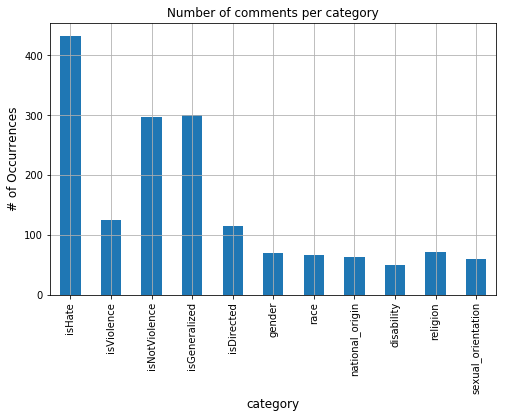

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

11 labels, 43 edges


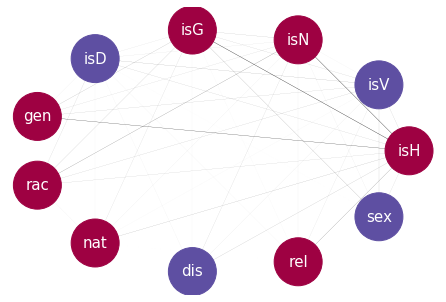

In [6]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
partition = clusterer.fit_predict(X,y)
membership_vector = to_membership_vector(partition)
import networkx as nx
names_dict = dict(enumerate(x[0:3].replace('-','-\n') for x in label_names))
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(
    clusterer.graph_,
    pos = nx.circular_layout(clusterer.graph_),
    labels = names_dict,
    with_labels = True,
    width = [1*x/y.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y.shape[1])],
    cmap = plt.cm.Spectral,
    node_size = 2300,
    font_size = 15,
    font_color = 'white'
    
)